In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


from sklearn.metrics import mean_squared_error
import load_mnist 

# Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray();

<Figure size 720x540 with 0 Axes>

In [2]:
# read MNIST data set and scale it
X0,y0,Xv,yv,X1,y1 = load_mnist.read([0,1,2,3,4,5,6,7,8,9], path="")
x0 = (1.0/255.0)*X0.astype('float64')
x1 = (1.0/255.0)*X1.astype('float64')
x2 = (1.0/255.0)*Xv.astype('float64')
y0 = y0.astype('float64')
y1 = y1.astype('float64')
y2 = yv.astype('float64')

MNIST, Classes:     10
Training Images:    (50000, 784)
Validation Images:  (10000, 784)
Test Images:        (10000, 784)


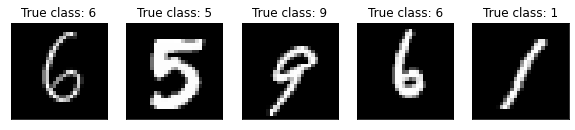

In [3]:
def plot_gallery(data, labels, shape, interpolation='nearest'):
    for i in range(data.shape[0]):
        plt.subplot(1, data.shape[0], (i + 1))
        plt.imshow(data[i].reshape(shape), interpolation=interpolation)
        plt.title(labels[i])
        plt.xticks(()), plt.yticks(())

subsample = np.random.permutation(x0.shape[0])[:5]
images = x0[subsample]
labels = ['True class: %d' % np.argmax(l) for l in y0[subsample]]
plot_gallery(images, labels, shape=(28, 28))

Globale Arrays und Variablen des Netzwerkes:

In [4]:
# Netzwerkparameter
mbs = 10                     # Größe der Minibatches
eta = 3.0                    # Lernrate
no_hidden = 36               # Anzahl versteckter Neuronen
epochs = 1                   # Anzahl Epochen
sizes = [784, no_hidden, 10] # dreischichtiges MPL mit 784 Eingangs-, no_hidden versteckten, 10 Ausgangsneuronen
num_layers = len(sizes)      # Anzahl Schichten

# Arrays für Gewichte und Schwellwerte (initialisiert mit Gaußschem Rauschen)
biases = [np.random.randn(y, 1) for y in sizes[1:]] # Schwellwerte
weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])] #Gewichte
print(weights[1].shape)

(10, 36)


Einige Hilfsfunktionen:

In [5]:
# Sigmoid (vektorisiert)
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))
    #return np.tanh(z)

# Ableitung des Sigmoids
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))
    #return 1.0/np.square(np.cosh(z))

# Ableitung der MSE-Kostenfunktion / Logistische Regression
def cost_derivative(output_activations, y):
    """Return the vector of partial derivatives \partial C_x /
    \partial a for the output activations."""
    
    #return np.nan_to_num(-1*(y-output_activations)/(output_activations*(1-output_activations)))
    
###  Überprüfen    (-y / output_activations)
    
    return (output_activations-y)

Vorwärtslauf durch das Netzwerk für Testläufe (Prädiktion):

In [6]:
def feedforward(a):
    """Return the output of the network if ``a`` is input."""
    for b, w in zip(biases, weights):
        a = sigmoid(np.dot(w, a)+b)
    return a

Backpropagation-Algorithmus für ein Paar aus Input x und Label y:

In [7]:
def backprop(x, y):
    """Return a tuple ``(nabla_b, nabla_w)`` representing the
    gradient for the cost function C_x.  ``nabla_b`` and
    ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
    to ``self.biases`` and ``self.weights``."""
    
    # Initialisiere Updates für Schwellwerte und Gewichte
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    
    # Vorwärtslauf
    activation = x # Initialisierung a^1 = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(biases, weights):
        z = np.dot(w, activation) + b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
    
    # Rückwärtslauf
    delta = cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1]) # Fehler am Output
    nabla_b[-1] = delta # Update Schwellwert in der Ausgangsschicht
    nabla_w[-1] = np.dot(delta, activations[-2].transpose()) # Update Gewichte in der Ausgangsschicht
    for l in range(2, num_layers): # Backpropagation
        z = zs[-l] # gewichteter Input
        sp = sigmoid_prime(z) # Ableitung der Aktivierungsfunktion
        delta = np.dot(weights[-l+1].transpose(), delta) * sp # Fehler in Schicht l
        nabla_b[-l] = delta # Update Schwellwert 
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose()) # Update Gewichte

    return (nabla_b, nabla_w)

Gemitteltes Update über einen Minibatch:

In [8]:
def update_mini_batch(xmb, ymb, eta):
    """Update the network's weights and biases by applying
    gradient descent using backpropagation to a single mini batch.
    The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
    is the learning rate."""
    global weights
    global biases

    # Initialisiere Updates für Schwellwerte und Gewichte
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    
    # Gehe durch alle Beispielpaare im Minibatch
    for i in range(xmb.shape[0]):
        x = np.reshape(xmb[i,:],(xmb.shape[1],1)).copy()
        if len(ymb.shape) == 2:
            y = np.reshape(ymb[i,:],(ymb.shape[1],1)).copy()
        else:
            y = ymb[i].copy()
        
        # Berechne Updates für alle Schichten über Backprop
        delta_nabla_b, delta_nabla_w = backprop(x, y)
        
        # Addiere einzelne Updates auf
        nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
        nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
    
    # Berechne neue Gewichte
    weights = [w-(eta/xmb.shape[0])*nw
                    for w, nw in zip(weights, nabla_w)]
    biases = [b-(eta/xmb.shape[0])*nb
                   for b, nb in zip(biases, nabla_b)]
    
    return (weights, biases)

Hilfsfunktion zur Evaluation des Netzwerkes auf den Testdaten:

In [9]:
def evaluate(x2, y2):
    """Return the number of test inputs for which the neural
    network outputs the correct result. Note that the neural
    network's output is assumed to be the index of whichever
    neuron in the final layer has the highest activation."""
    
    correct = 0 # Anzahl korrekt klassifizierter Testbeispiele
    
    # Gehe den Testdatensatz durch
    for i in range(0, x2.shape[0]):
        x = np.reshape(x2[i,:],(x2.shape[1],1)).copy()
        if len(y2.shape) == 2:
            y = np.reshape(y2[i,:],(y2.shape[1],1)).copy()
        else:
            y = y2[i].copy()
        
        # Vorwärtslauf
        ypred = feedforward(x)
        
        # Label ist in one-hot-Codierung: korrekte Klasse ist 1, alle anderen 0
        c = np.argmax(y)
        
        # Index des maximal aktivierten Outputs ist die Entscheidung des Netzwerk
        cpred = np.argmax(ypred)
        
        # Falls beide übereinstimmen, addiere zur Gesamtzahl
        if c == cpred:
            correct += 1
        
    return correct

Stochastischer Gradientenabstieg:

In [10]:
def SGD(x0, y0, epochs, mini_batch_size, eta, x2, y2):

    n_test = x2.shape[0] # Anzahl Testdaten
    n = x0.shape[0]      # Anzahl Trainingsdaten
    
    # gehe durch alle Epochen
    acc_val = np.zeros(epochs)
    for j in range(epochs):
        
        # Bringe die Trainingsdaten in eine zufällige Reihenfolge für jede Epoche
        p = np.random.permutation(n) # Zufällige Permutation aller Indizes von 0 .. n-1
        x0 = x0[p,:]
        y0 = y0[p]
        
        # Zerlege den permutierten Datensatz in Minibatches 
        for k in range(0, n, mini_batch_size):
            xmb = x0[k:k+mini_batch_size,:]
            if len(y0.shape) == 2:
                ymb = y0[k:k+mini_batch_size,:]
            else:
                ymb = y0[k:k+mini_batch_size]
            update_mini_batch(xmb, ymb, eta)
        
        # Gib Performance aus
        acc_val[j] = evaluate(x2, y2)
        print("Epoch {0}: {1} / {2}".format(j, acc_val[j], n_test))
    
    return acc_val

Training:

In [11]:
acc_val = SGD(x0, y0, epochs, mbs, eta, x2, y2)

Epoch 0: 9081.0 / 10000


Evaluation auf den unabhängigen Testdaten:

In [12]:
print("Test accuracy: {0} / {1}".format(evaluate(x1, y1), x1.shape[0]))

Test accuracy: 8965 / 10000


Lernkurve (Genauigkeit auf Validierungsdatensatz):

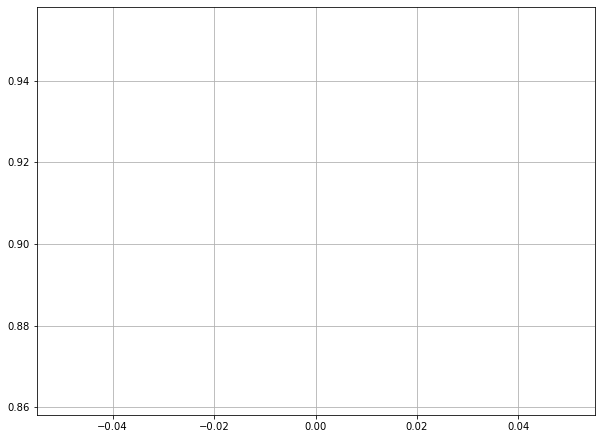

In [13]:
plt.plot(acc_val/x2.shape[0]);

Trainierte rezeptive Felder:

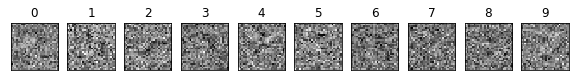

In [14]:
labels = range(no_hidden)
plot_gallery(weights[0][:10,:],labels, shape=(28, 28))

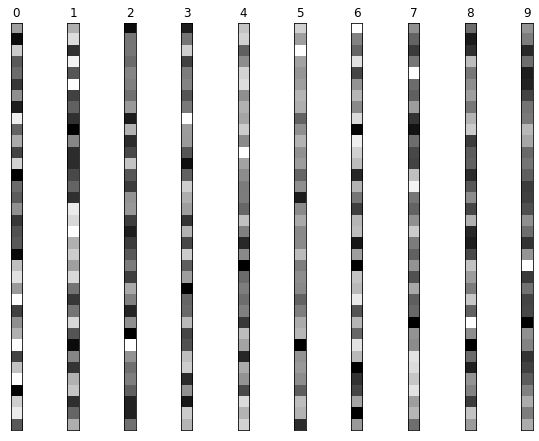

In [15]:
labels = range(10)
plot_gallery(weights[1],labels, shape=(36,1))

### Aufgabe 1: Spielzeugdatensatz

#### 1.
Erzeugen Sie 200 zweidimensionale Trainingsdatenpunkte mithilfe einer Gleichverteilung über dem Gebiet [−6,6] × [−6,6]. Speichern Sie diese in einer 200×2 Designmatrix.

In [16]:
DMatrix = []

DMatrix = np.random.uniform(-6, 6, size=(200, 2))

DMatrix.shape

(200, 2)

#### 2.
Die Klassenlabels 0 und 1 werden so vergeben, dass alle Datenpunkte im 1. und 3. Quadranten das Label 1 und im 2. und 4. Quadranten das Label 0 erhalten. Speichern Sie die Labels in einem Array.

In [17]:
class_a = []

for i in DMatrix:
    if i[0] <= 0 and i[1] <= 0 or i[0] >= 0 and i[1] >= 0:
        class_a.append(1)
    else:
        class_a.append(0)

#### 3.
Erzeugen Sie einen gleich großen Testdatensatz nach demselben Prinzip. Stellen Sie beide Datensätze zur Überprüfung als Scatterplot dar.

In [18]:
TestMatrix = []

TestMatrix = np.random.uniform(-6, 6, size=(200, 2))

class_test = []

for i in TestMatrix:
    if i[0] <= 0 and i[1] <= 0 or i[0] >= 0 and i[1] >= 0:
        class_test.append(1)
    else:
        class_test.append(0)

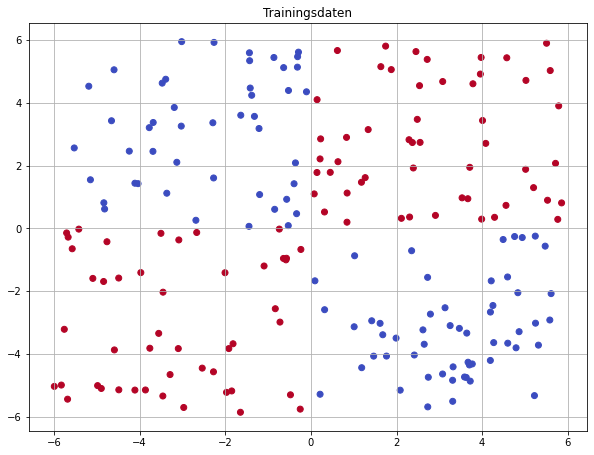

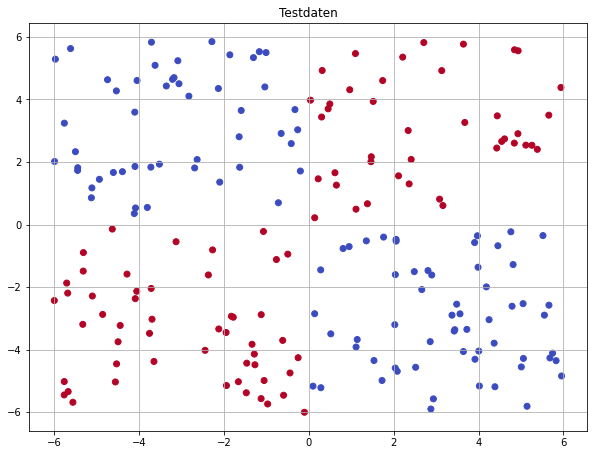

In [19]:
plt.scatter(x = DMatrix[:,0], y = DMatrix[:,1], c = class_a, cmap = "coolwarm")
plt.title("Trainingsdaten")
plt.show()

plt.scatter(x = TestMatrix[:,0], y = TestMatrix[:,1], c = class_test, cmap = "coolwarm")
plt.title("Testdaten")
plt.show()

#### 4.
Das in der Vorlesung dargestellte Experiment operiert nicht direkt auf den Inputdaten, sondern auf 2 Merkmalen, die mithilfe zweier Neuronen mit fixem Gewichtsvektor berechnet werden: ein Neuron teilt die Inputebene waagrecht entlang der x-Achse, das andere senkrecht entlang der y-Achse. Wie muss der Gewichtsvektor für das jeweilige Neuron aussehen?

Gewichtsvektor für x-Achse: [12/99], [0]

Gewichtsvektor für y-Achse: [0], [12/99]

#### 5.
Berechnen Sie die Entscheidungsfunktion beider Neuron mit der im Beispielcode angegebenen sigmoiden Aktivierungsfunktion auf einem 100 × 100-Gitter innerhalb des Gebietes [−6,6] × [−6,6] und stellen Sie diese zur Überprüfung als Farbbild dar.

In [20]:
x_val = np.zeros((100, 100))
y_val = np.zeros((100, 100))
x_achse = np.zeros((100, 100))
y_achse = np.zeros((100, 100))
w1 = np.array([0, 1])
w2 = np.array([1, 0])
grid = np.zeros((10000, 2))

for i in range(x_val.shape[0]):
    for j in range(x_val.shape[1]):
        x_cord = j / 100 * 12 - 6
        y_cord = i / 100 * 12 - 6
        
        p = np.array([x_cord,y_cord])  
        x_val[i,j] = sigmoid(p.dot(w1))
        y_val[i,j] = sigmoid(p.dot(w2))    
        x_achse[i,j] = x_cord
        y_achse[i,j] = y_cord 
        
        grid[i*x_val.shape[1] + j, 0] = x_cord
        grid[i*x_val.shape[1] + j, 1] = y_cord

    

<ipython-input-21-7d408022b9e3>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x_achse, y_achse, y_val, cmap = "YlGnBu")


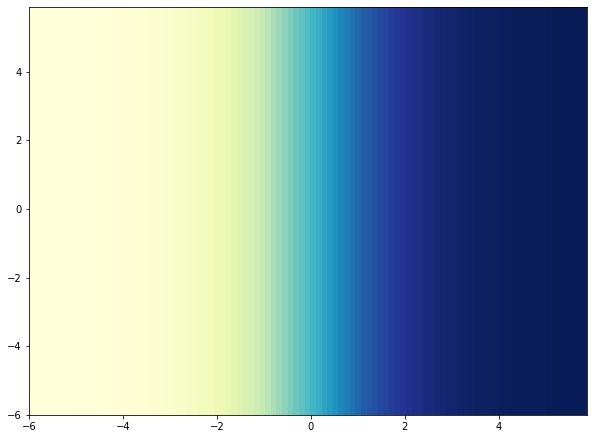

<ipython-input-21-7d408022b9e3>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x_achse, y_achse, x_val, cmap = "YlGnBu")


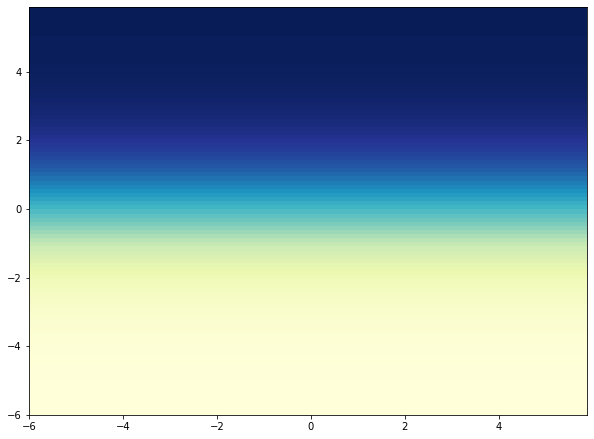

In [21]:
plt.pcolor(x_achse, y_achse, y_val, cmap = "YlGnBu")
plt.show()
plt.pcolor(x_achse, y_achse, x_val, cmap = "YlGnBu")
plt.show()

#### 6.
Da die Eingangsneuronen nicht mittrainiert werden, können wir deren Output schon im Vorfeld berechnen. Erzeugen Sie dazu neue Designmatritzen für den Trainings- und Testdatensatz, so dass die erste Spalte den Output des ersten Neurons und die zweite Spalte den Output des zweiten Neurons enthält. __Erzeugen Sie auch eine entsprechende Designmatrix für Ihr 100 × 100-Gitter,__ das wir später zu Darstellungszwecken brauchen werden. Wichtig: arbeiten Sie im Folgenden nur mit diesen transformierten Designmatritzen, um korrekte Ergebnisse zu erhalten!

In [22]:
DMatrix_new = np.zeros(DMatrix.shape)
TestMatrix_new = np.zeros(DMatrix.shape)
grid_new = np.zeros(grid.shape)

for i in range(0,200):
    DMatrix_new[i][0] = sigmoid(DMatrix[i].dot(w1))
    DMatrix_new[i][1] = sigmoid(DMatrix[i].dot(w2))
    
    TestMatrix_new[i][0] = sigmoid(TestMatrix[i].dot(w1))
    TestMatrix_new[i][1] = sigmoid(TestMatrix[i].dot(w2))
    
for i,p in enumerate(grid):
    grid_new[i,0] = sigmoid(p.dot(w1))
    grid_new[i,1] = sigmoid(p.dot(w2))

### 2.  Training eines MLPs auf den Spielzeugdaten

#### 1.

Setzen Sie im Code die Größe der Minibatches auf 10, die Anzahl der Epochen auf 150 und die Lernrate auf 0.03. Ändern Sie die Netzarchitektur so ab, dass sie 2 Eingangsneuronen, 2 verdeckte Schichten mit jeweils 2 Neuronen und 1 Ausgangsneuron haben. Überprüfen Sie die Größen der sich daraus ergebenden Gewichtsmatritzen auf Korrektheit

In [23]:
# Netzwerkparameter
mbs = 10                             # Größe der Minibatches
eta =0.03                       # Lernrate
#eta = 1.0                            # Lernrate Aufgabe 4
no_hidden = 2                        # Anzahl versteckter Neuronen
epochs = 150                         # Anzahl Epochen
sizes = [2, no_hidden, no_hidden, 1] # zweischichtiges MPL mit 2 Eingangs-, jeweils 2 versteckten, 1 Ausgangsneuronen
num_layers = len(sizes)              # Anzahl Schichten

# Arrays für Gewichte und Schwellwerte (initialisiert mit Gaußschem Rauschen)
biases = [np.random.randn(y, 1) for y in sizes[1:]] # Schwellwerte
weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])] #Gewichte

print(weights[1].shape)
print("Gewichte:", weights)
print("Anzahl Schichten:", num_layers)

(2, 2)
Gewichte: [array([[-1.65964113, -0.36117757],
       [-1.05263625,  0.75672796]]), array([[ 1.72057125, -0.14199306],
       [ 0.78892237,  1.06942167]]), array([[-1.71036825, -0.53050068]])]
Anzahl Schichten: 4


#### 2. 
Der Beispielcode verwendet One-Hot-Coding für die Labels, in unserem Beispiel sind die Klassenzugehörigkeiten aber durch die Klassenindizes 0 und 1 codiert. Wir müssen daher die Funktion evaluate() im Code so abändern, dass ein Beispiel als korrekt klassifiziert gilt, wenn bei Klasse 0 der MLP-Output kleiner als 0.5 ist und bei Klasse 1 größer als 0.5. 
Berechnen Sie zusätzlich den MSE in dieser Funktion bei jedem Aufruf und speichern Sie diesen in einem zusätzlichen Array ab.

In [24]:
x0 = DMatrix_new
x1 = DMatrix_new
x2 = TestMatrix_new

y0 = np.array(class_a)
y1 = np.array(class_a)
y2 = np.array(class_test)



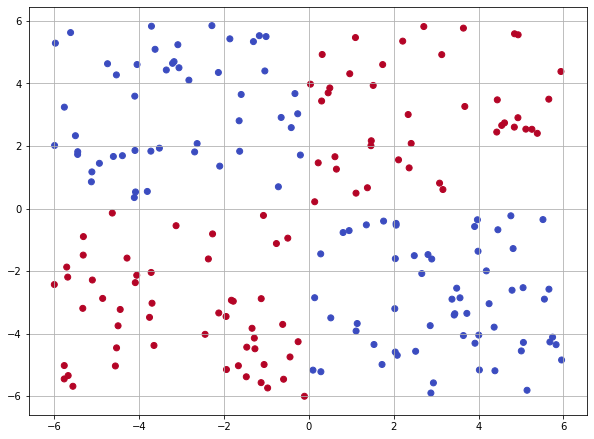

In [25]:
plt.scatter(x = TestMatrix[:,0], y = TestMatrix[:,1], c = class_test, cmap = "coolwarm")
plt.show()

In [26]:
# Sigmoid (vektorisiert)
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

# Ableitung des Sigmoids
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

# Ableitung der MSE-Kostenfunktion
def cost_derivative(output_activations, y):
    return (output_activations-y)

In [27]:

def evaluate(x2, y2):
    
    correct = 0 # Anzahl korrekt klassifizierter Testbeispiele
    MSE = 0
    # Gehe den Testdatensatz durch
    for i in range(0, x2.shape[0]):
        x = np.reshape(x2[i,:],(x2.shape[1],1)).copy()
        if len(y2.shape) == 2:
            y = np.reshape(y2[i,:],(y2.shape[1],1)).copy()
        else:
            y = y2[i].copy()
        
        # Vorwärtslauf
        ypred = feedforward(x)[0][0]
        
        #Abänderung für Spielzeugdatensatz, kein one-hot, nur noch 1 oder 0
        c = y
        
        # Index des maximal aktivierten Outputs ist die Entscheidung des Netzwerk
        #cpred = np.argmax(ypred)
        #Abänderung für Spielzeugdatensatz, <0.5 steht für 0, >0.5 für 1
        if ypred >= 0.5:
            cpred = 1.0
        else:
            cpred = 0.0
        #print(y, ypred, cpred)
        MSE += (y - ypred)**2
        
        # Falls beide übereinstimmen, addiere zur Gesamtzahl
        if c == cpred:
            correct += 1
        
    return correct,MSE/x2.shape[0]

In [28]:
def SGD(x0, y0, epochs, mini_batch_size, eta, x2, y2):

    n_test = x2.shape[0] # Anzahl Testdaten
    n = x0.shape[0]      # Anzahl Trainingsdaten
    
    # gehe durch alle Epochen
    acc_val = np.zeros(epochs)
    MSE = np.zeros(epochs)
    for j in range(epochs):
        
        # Bringe die Trainingsdaten in eine zufällige Reihenfolge für jede Epoche
        p = np.random.permutation(n) # Zufällige Permutation aller Indizes von 0 .. n-1
        x0 = x0[p,:]
        y0 = y0[p]
        
        # Zerlege den permutierten Datensatz in Minibatches 
        for k in range(0, n, mini_batch_size):
            xmb = x0[k:k+mini_batch_size,:]
            if len(y0.shape) == 2:
                ymb = y0[k:k+mini_batch_size,:]
            else:
                ymb = y0[k:k+mini_batch_size]
            update_mini_batch(xmb, ymb, eta)
        
        # Gib Performance aus
        acc_val[j],MSE[j] = evaluate(x2, y2)
        print("Epoch {0}: {1} / {2}".format(j, acc_val[j], n_test))
    
    return acc_val,MSE

#### 3.
Trainieren Sie Ihr Netz mit den Trainingsdaten als Validierungsdaten und testen Sie es auf Ihren Testdaten. Stellen Sie die Lernkurven für Genauigkeit und MSE als Plots dar. Beachten Sie hierbei, dass unser Lernproblem nicht konvex ist, so dass die Optimierungzuweilen in lokalen Minima hängenbleiben kann. Wiederholen Sie Ihren Versuch daher mehrere Male und vergeleichen Sie die Ergebnisse.

In [29]:
biases = [np.random.randn(y, 1) for y in sizes[1:]] # Schwellwerte
weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])] #Gewichte
acc_val,MSE = SGD(x0, y0, epochs, mbs, eta, x0, y0)

Epoch 0: 99.0 / 200
Epoch 1: 99.0 / 200
Epoch 2: 99.0 / 200
Epoch 3: 99.0 / 200
Epoch 4: 99.0 / 200
Epoch 5: 99.0 / 200
Epoch 6: 99.0 / 200
Epoch 7: 99.0 / 200
Epoch 8: 99.0 / 200
Epoch 9: 99.0 / 200
Epoch 10: 99.0 / 200
Epoch 11: 99.0 / 200
Epoch 12: 99.0 / 200
Epoch 13: 99.0 / 200
Epoch 14: 99.0 / 200
Epoch 15: 99.0 / 200
Epoch 16: 99.0 / 200
Epoch 17: 99.0 / 200
Epoch 18: 99.0 / 200
Epoch 19: 99.0 / 200
Epoch 20: 99.0 / 200
Epoch 21: 99.0 / 200
Epoch 22: 99.0 / 200
Epoch 23: 99.0 / 200
Epoch 24: 99.0 / 200
Epoch 25: 99.0 / 200
Epoch 26: 99.0 / 200
Epoch 27: 99.0 / 200
Epoch 28: 99.0 / 200
Epoch 29: 99.0 / 200
Epoch 30: 99.0 / 200
Epoch 31: 99.0 / 200
Epoch 32: 99.0 / 200
Epoch 33: 99.0 / 200
Epoch 34: 99.0 / 200
Epoch 35: 99.0 / 200
Epoch 36: 99.0 / 200
Epoch 37: 99.0 / 200
Epoch 38: 99.0 / 200
Epoch 39: 99.0 / 200
Epoch 40: 99.0 / 200
Epoch 41: 99.0 / 200
Epoch 42: 99.0 / 200
Epoch 43: 99.0 / 200
Epoch 44: 99.0 / 200
Epoch 45: 99.0 / 200
Epoch 46: 99.0 / 200
Epoch 47: 99.0 / 200
Ep

In [30]:
print("Test accuracy: {0} / {1}".format(evaluate(x2, y2), x2.shape[0]))

Test accuracy: (100, 0.2503073598518597) / 200


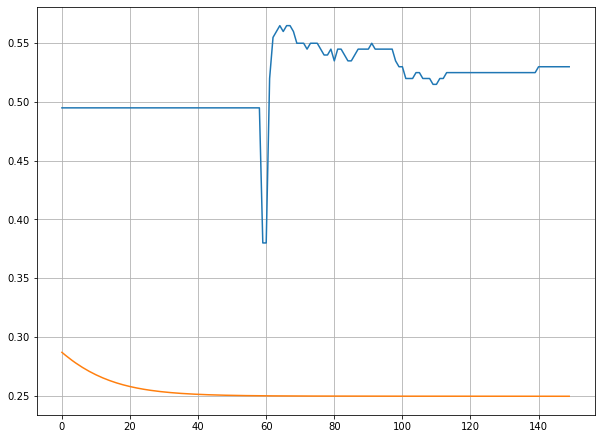

In [31]:
plt.plot(acc_val/x2.shape[0]);
plt.plot(MSE);
#plt.plot(cost);

#### 4.
Berechnen Sie die Entscheidungsfunktion Ihres MLPs für Ihr 100 × 100-Gitter und stellen Sie diese gemeinsam mit dem Scatterplot Ihrer Trainingsdaten dar.

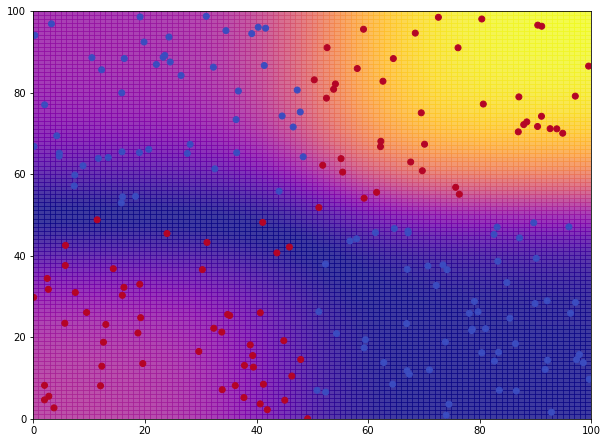

In [32]:
c_grid = np.zeros(grid.shape)
for i,p in enumerate(grid_new):
    c_grid[i] = feedforward(p)[0][0]
#plt.pcolor(c_grid.reshape(100,100,2), alpha=.8, cmap='plasma');
plt.pcolor(np.reshape(c_grid, (100,100,2))[:,:,0], alpha=.8, cmap='plasma');
plt.scatter(x = (TestMatrix[:,0]+6)/12*100, y = (TestMatrix[:,1]+6)/12*100, c = class_test, cmap = "coolwarm")

### 3.  Nachvollziehen der Beispiele aus der Vorlesung
Das Netz aus der Vorlesung verwendet als Aktivierungsfunktion den Tangens hyperbolicus (np.tanh()). Passen Sie die Funktionen sigmoid() und sigmoid_prime() entsprechend an. Achtung: kommentieren Sie den bisherigen Code für die Sigmoidfunktion nur aus, wir werden ihn in der nächsten Aufgabe nochmals benötigen. Da die Ausgangswerte von tanh im Intervall [−1,1] statt [0,1] liegen, müssen wir hierfür nochmals die Funktion evaluate() entsprechend anpassen. Vollziehen Sie die 3 Beispiele aus der Vorlesung nach.

In [33]:
# Sigmoid (vektorisiert)
def sigmoid(z):
    """The sigmoid function."""
    return np.tanh(z)

# Ableitung des Sigmoids
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return 1 - np.tanh(z)**2

# Ableitung der MSE-Kostenfunktion
def cost_derivative(output_activations, y):
    return (output_activations-y)

In [34]:

def evaluate(x2, y2):
    
    correct = 0 # Anzahl korrekt klassifizierter Testbeispiele
    MSE = 0
    # Gehe den Testdatensatz durch
    for i in range(0, x2.shape[0]):
        x = np.reshape(x2[i,:],(x2.shape[1],1)).copy()
        if len(y2.shape) == 2:
            y = np.reshape(y2[i,:],(y2.shape[1],1)).copy()
        else:
            y = y2[i].copy()
        
        # Vorwärtslauf
        ypred = feedforward(x)[0][0]
        
        #Abänderung für Spielzeugdatensatz, kein one-hot, nur noch 1 oder 0
        c = y
        
        # Index des maximal aktivierten Outputs ist die Entscheidung des Netzwerk
        #cpred = np.argmax(ypred)
        #Abänderung für Spielzeugdatensatz, <0.5 steht für 0, >0.5 für 1
        if ypred >= 0.0:
            cpred = 1.0
        else:
            cpred = 0.0
        #print(y, ypred, cpred)
        MSE += (y - ypred)**2
        
        # Falls beide übereinstimmen, addiere zur Gesamtzahl
        if c == cpred:
            correct += 1
        
    return correct,MSE/x2.shape[0]

In [35]:
# Netzwerkparameter
mbs = 10                             # Größe der Minibatches
eta =0.03                       # Lernrate
#eta = 1.0                            # Lernrate Aufgabe 4
no_hidden = 2                        # Anzahl versteckter Neuronen
epochs = 150                         # Anzahl Epochen
sizes = [2, no_hidden, no_hidden, 1] # zweischichtiges MPL mit 2 Eingangs-, jeweils 2 versteckten, 1 Ausgangsneuronen
num_layers = len(sizes)              # Anzahl Schichten

# Arrays für Gewichte und Schwellwerte (initialisiert mit Gaußschem Rauschen)
biases = [np.random.randn(y, 1) for y in sizes[1:]] # Schwellwerte
weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])] #Gewichte

print(weights[1].shape)
print("Gewichte:", weights)
print("Anzahl Schichten:", num_layers)

(2, 2)
Gewichte: [array([[ 1.80079613, -0.03659474],
       [-0.57747977,  0.51642429]]), array([[ 0.56368658,  1.97767794],
       [ 0.76818977, -0.12470877]]), array([[0.57814543, 1.32858773]])]
Anzahl Schichten: 4


In [36]:
biases = [np.random.randn(y, 1) for y in sizes[1:]] # Schwellwerte
weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])] #Gewichte
acc_val,MSE = SGD(x0, y0, epochs, mbs, eta, x0, y0)

Epoch 0: 99.0 / 200
Epoch 1: 99.0 / 200
Epoch 2: 99.0 / 200
Epoch 3: 99.0 / 200
Epoch 4: 99.0 / 200
Epoch 5: 99.0 / 200
Epoch 6: 99.0 / 200
Epoch 7: 99.0 / 200
Epoch 8: 99.0 / 200
Epoch 9: 99.0 / 200
Epoch 10: 99.0 / 200
Epoch 11: 101.0 / 200
Epoch 12: 101.0 / 200
Epoch 13: 104.0 / 200
Epoch 14: 104.0 / 200
Epoch 15: 104.0 / 200
Epoch 16: 104.0 / 200
Epoch 17: 104.0 / 200
Epoch 18: 104.0 / 200
Epoch 19: 104.0 / 200
Epoch 20: 105.0 / 200
Epoch 21: 104.0 / 200
Epoch 22: 104.0 / 200
Epoch 23: 104.0 / 200
Epoch 24: 101.0 / 200
Epoch 25: 101.0 / 200
Epoch 26: 101.0 / 200
Epoch 27: 101.0 / 200
Epoch 28: 100.0 / 200
Epoch 29: 101.0 / 200
Epoch 30: 101.0 / 200
Epoch 31: 101.0 / 200
Epoch 32: 99.0 / 200
Epoch 33: 101.0 / 200
Epoch 34: 101.0 / 200
Epoch 35: 101.0 / 200
Epoch 36: 101.0 / 200
Epoch 37: 103.0 / 200
Epoch 38: 104.0 / 200
Epoch 39: 104.0 / 200
Epoch 40: 104.0 / 200
Epoch 41: 104.0 / 200
Epoch 42: 105.0 / 200
Epoch 43: 106.0 / 200
Epoch 44: 107.0 / 200
Epoch 45: 106.0 / 200
Epoch 46: 

In [37]:
print("Test accuracy: {0} / {1}".format(evaluate(x2, y2), x2.shape[0]))

Test accuracy: (137, 0.05044384114525045) / 200


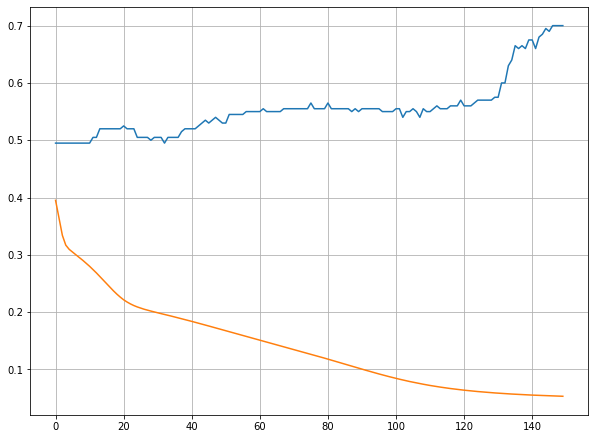

In [38]:
plt.plot(acc_val/x2.shape[0]);
plt.plot(MSE);

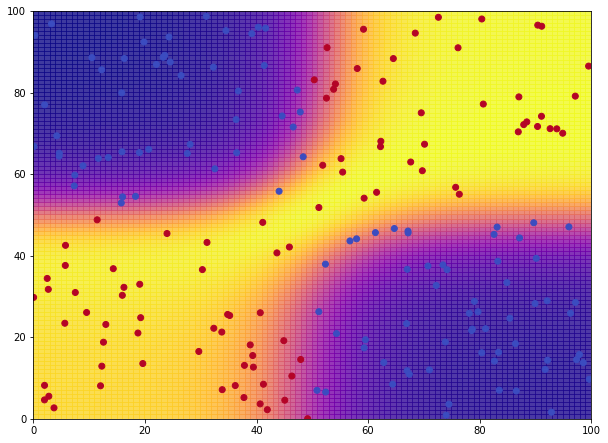

In [39]:
grid_ev = np.zeros(grid.shape)
for i,p in enumerate(grid_new):
    x = np.reshape(p,(p.shape[0],1)).copy()
    grid_ev[i] = feedforward(x)[0][0]
#plt.pcolor(c_grid.reshape(100,100,2), alpha=.8, cmap='plasma');
plt.pcolor(np.reshape(grid_ev, (100,100,2))[:,:,0], alpha=.8, cmap='plasma');
plt.scatter(x = (TestMatrix[:,0]+6)/12*100, y = (TestMatrix[:,1]+6)/12*100, c = class_test, cmap = "coolwarm")

### 4.  Logistische Regression

In [40]:
# Sigmoid (vektorisiert)
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

# Ableitung des Sigmoids
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

# Ableitung der MSE-Kostenfunktion
def cost_derivative(output_activations, y):
    return np.nan_to_num(-y/output_activations + ((1-y)/(1-output_activations)))

In [41]:

def evaluate(x2, y2):
    
    correct = 0 # Anzahl korrekt klassifizierter Testbeispiele
    logReg = 0
    # Gehe den Testdatensatz durch
    for i in range(0, x2.shape[0]):
        x = np.reshape(x2[i,:],(x2.shape[1],1)).copy()
        if len(y2.shape) == 2:
            y = np.reshape(y2[i,:],(y2.shape[1],1)).copy()
        else:
            y = y2[i].copy()
        
        # Vorwärtslauf
        ypred = feedforward(x)[0][0]
        
        #Abänderung für Spielzeugdatensatz, kein one-hot, nur noch 1 oder 0
        c = y
        
        # Index des maximal aktivierten Outputs ist die Entscheidung des Netzwerk
        #cpred = np.argmax(ypred)
        #Abänderung für Spielzeugdatensatz, <0.5 steht für 0, >0.5 für 1
        if ypred >= 0.5:
            cpred = 1.0
        else:
            cpred = 0.0
        #print(y, ypred, cpred)
        logReg += np.nan_to_num(-y * np.log(ypred) - (1 - y) * np.log(1 - ypred))
        
        
        # Falls beide übereinstimmen, addiere zur Gesamtzahl
        if c == cpred:
            correct += 1
        
    return correct,logReg/x2.shape[0]

In [46]:
eta = 1.0
biases = [np.random.randn(y, 1) for y in sizes[1:]] # Schwellwerte
weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])] #Gewichte
acc_val,MSE = SGD(x0, y0, epochs, mbs, eta, x0, y0)

Epoch 0: 99.0 / 200
Epoch 1: 101.0 / 200
Epoch 2: 101.0 / 200
Epoch 3: 99.0 / 200
Epoch 4: 101.0 / 200
Epoch 5: 99.0 / 200
Epoch 6: 101.0 / 200
Epoch 7: 99.0 / 200
Epoch 8: 101.0 / 200
Epoch 9: 99.0 / 200
Epoch 10: 101.0 / 200
Epoch 11: 99.0 / 200
Epoch 12: 99.0 / 200
Epoch 13: 99.0 / 200
Epoch 14: 101.0 / 200
Epoch 15: 101.0 / 200
Epoch 16: 99.0 / 200
Epoch 17: 99.0 / 200
Epoch 18: 101.0 / 200
Epoch 19: 101.0 / 200
Epoch 20: 123.0 / 200
Epoch 21: 113.0 / 200
Epoch 22: 99.0 / 200
Epoch 23: 99.0 / 200
Epoch 24: 139.0 / 200
Epoch 25: 101.0 / 200
Epoch 26: 101.0 / 200
Epoch 27: 99.0 / 200
Epoch 28: 99.0 / 200
Epoch 29: 99.0 / 200
Epoch 30: 101.0 / 200
Epoch 31: 99.0 / 200
Epoch 32: 139.0 / 200
Epoch 33: 99.0 / 200
Epoch 34: 99.0 / 200
Epoch 35: 99.0 / 200
Epoch 36: 133.0 / 200
Epoch 37: 141.0 / 200
Epoch 38: 138.0 / 200
Epoch 39: 140.0 / 200
Epoch 40: 99.0 / 200
Epoch 41: 133.0 / 200
Epoch 42: 141.0 / 200
Epoch 43: 143.0 / 200
Epoch 44: 141.0 / 200
Epoch 45: 173.0 / 200
Epoch 46: 99.0 / 2

In [43]:
print("Test accuracy: {0} / {1}".format(evaluate(x2, y2), x2.shape[0]))

Test accuracy: (150, 0.3361777350236415) / 200


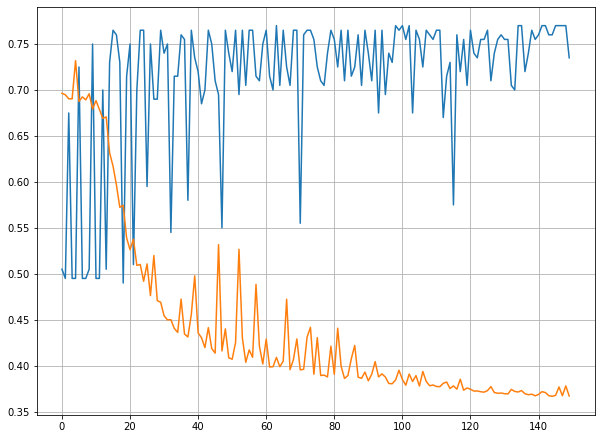

In [44]:
plt.plot(acc_val/x2.shape[0]);
plt.plot(MSE);

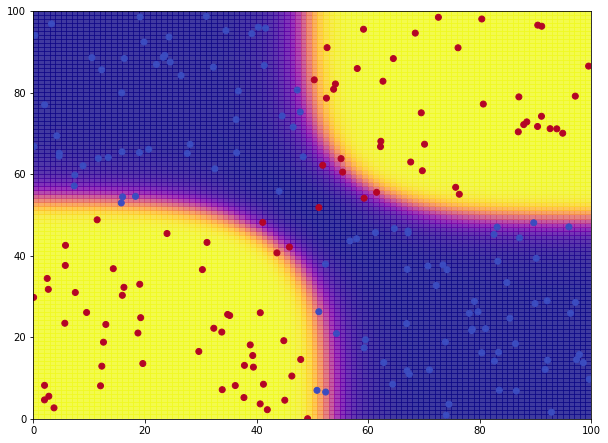

In [47]:
grid_ev = np.zeros(grid.shape)
for i,p in enumerate(grid_new):
    x = np.reshape(p,(p.shape[0],1)).copy()
    grid_ev[i] = feedforward(x)[0][0]
#plt.pcolor(c_grid.reshape(100,100,2), alpha=.8, cmap='plasma');
plt.pcolor(np.reshape(grid_ev, (100,100,2))[:,:,0], alpha=.8, cmap='plasma');
plt.scatter(x = (TestMatrix[:,0]+6)/12*100, y = (TestMatrix[:,1]+6)/12*100, c = class_test, cmap = "coolwarm")

Eine alternative, besser an das Klassifikationsszenario angepasste Kostenfunktion statt des MSE ist die Kostenfunktion für die logistische Regression

C=−ylog(aL)−(1−y) log(1−aL).

Damit Sie diese in Ihrem Beispiel anwenden können, müssen Sie die Ableitung∇aLCberechnen und die Funktioncost_derivative()entsprechend abändern. Da die logistischeRegression davon ausgeht, dass der Output des Netzes eine Wahrscheinlichkeit zwischen 0und 1 ist, können wir hierfür nicht dentanh()als Aktivierungsfunktion verwenden. MachenSie daher Ihre Änderungen aus Aufgabe 3 rückgängig, so dass Sie wieder eine sigmoideAktivierungsfunktion haben. In der Funktionevaluate()sollte natürlich statt des MSE die Kostenfunktion der logistischen Regression ausgegeben werden, um zu überprüfen, obtatsächlich ein Gradientenabstieg stattfindet. Weiterhin ist es nützlich, sowohl aufCwie auf∇aLCdie Funktionnp.nan_to_num()anzuwenden, da hier zuweilen numerische Problemeauftreten können. Auch die Lernrate muss angepasst werden:η= 1.0funktioniert hierdeutlich besser.